# Milestone 3 - Fictional worlds analysis
...

In [216]:
import os
from tqdm import tqdm

# array and dataframes
import pandas as pd
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# natural language processing
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_md")

# Import extra functions and datasets

In [217]:
import preprocessing
import topic_modeling

In [218]:
folder_path = os.path.abspath('MovieSummaries')
df_movies, df_summaries = preprocessing.get_datasets(folderpath=folder_path)

In [219]:
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)
df_fictional_summaries, df_fictional = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries, return_df_fictional=True)
df_movies_summaries = df_movies.merge(df_summaries, on='Wikipedia_movie_ID', how='inner')
# takes around 20s

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre  release_year
0              975900         /m/01jfsb         Thriller        2001.0
1              975900          /m/06n90  Science Fiction        2001.0
2              975900          /m/03npn           Horror        2001.0
3              975900         /m/03k9fj        Adventure        2001.0
4              975900          /m/0fdjb     Supernatural        2001.0
The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [220]:
imdb_title_genre_df = pd.read_table(r"C:\Users\Cyrill\Documents\ada\project\project data\IMBD free\title.basics.tsv", delimiter='\t')
# takes 30s

C:\Users\Cyrill\AppData\Local\Temp\ipykernel_9588\2811791558.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table(r"C:\Users\Cyrill\Documents\ada\project\project data\IMBD free\title.basics.tsv", delimiter='\t')


# sentiment analysis of all movie summaries and initial assessment

In [221]:
from scipy import stats
from nltk import sent_tokenize
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe("spacytextblob")

def sentiment_analysis(text):
    sentiment = nlp(text)._.polarity
    return sentiment

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [222]:
df_movies_summaries['sentence_sentiment_score'] = df_movies_summaries['movie_summary'].apply(sentiment_analysis)

In [223]:
df_sentiment_score_backup = df_movies_summaries

In [224]:
df_movies_summaries['n_sentences'] = df_movies_summaries['movie_summary'].apply(count_sentences)

Do we need to consider the length of the summaries?

In [178]:
sentiment_score_per_length = []
n_summaries_per_length = []
for i in range(1,100):
    temp = df_movies_summaries[df_movies_summaries['n_sentences'] == i]
    sentiment_score_per_length.append(np.mean(temp['sentence_sentiment_score']))
    n_summaries_per_length.append(len(temp))

(0.0, 0.1)

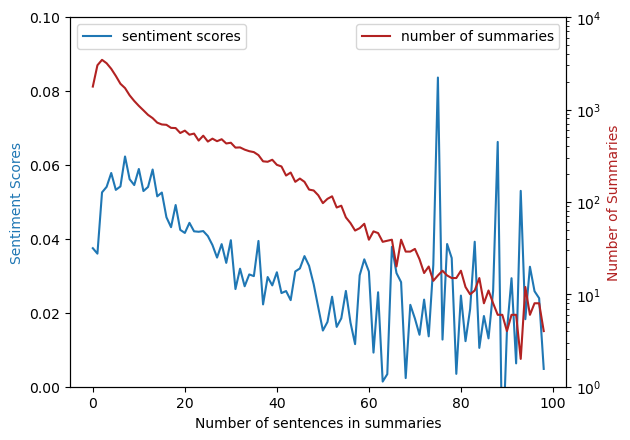

In [179]:
fig,ax = plt.subplots()
ax.plot(sentiment_score_per_length, label='sentiment scores')
ax2 = ax.twinx()
ax2.plot(n_summaries_per_length, label='number of summaries', color='firebrick')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('Number of sentences in summaries')
ax.set_ylabel('Sentiment Scores', color='#1f77b4')
ax2.set_ylabel('Number of Summaries', color='firebrick')
ax2.set_yscale('log')
ax2.set_ylim(1,10000)
ax.set_ylim(0,0.1)

What are the sentiment scores of short (3-20 sentences) and long (30-50 sentences) movie summaries?

In [180]:
short_summaries = df_movies_summaries[(df_movies_summaries['n_sentences'] >= 3) &
                                      (df_movies_summaries['n_sentences'] <= 20)]
long_summaries = df_movies_summaries[(df_movies_summaries['n_sentences'] >= 30) &
                                            (df_movies_summaries['n_sentences'] <= 50)]
print('short: ', np.mean(short_summaries['sentence_sentiment_score']))
print('long: ', np.mean(long_summaries['sentence_sentiment_score']))
print('all: ', np.mean(df_movies_summaries['sentence_sentiment_score']))

short:  0.05423304293552305
long:  0.030298011615262035
all:  0.046300941285147654


In [181]:
sentiment_t_value, sentiment_p_value = stats.ttest_ind(short_summaries['sentence_sentiment_score'],
                                                        long_summaries['sentence_sentiment_score'],
                                                          nan_policy='omit')

print('p-value: ', sentiment_p_value)
print('t-value:', sentiment_t_value)

p-value:  6.199533574735384e-37
t-value: 12.712775308697783


There is also a very big variance for the sentiment scores!

(-0.75, 0.75)

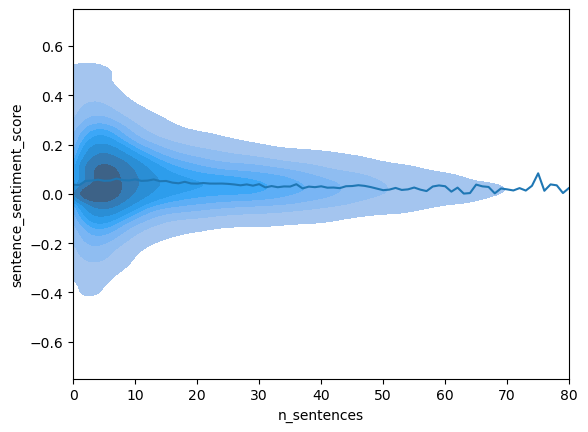

In [182]:
contour_plot_df = df_movies_summaries[df_movies_summaries['n_sentences'] <= 100]

sns.kdeplot(data=contour_plot_df, x="n_sentences", y="sentence_sentiment_score",fill=True)
plt.plot(sentiment_score_per_length)
plt.xlim(0,80)
plt.ylim(-0.75,0.75)

What happens if we look at specific periods in time? Do old movies have a high sentiment score because they more likely to have short summaries?

In [183]:
time_periods = [0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023]
time_period_labels = ['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', ' after 2010s']

time_periods_df_movies_summaries = []

for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries[(df_movies_summaries.release_year > time_periods[i-1])
                                    & (df_movies_summaries.release_year <= time_periods[i])]
        time_periods_df_movies_summaries.append(temp)

How is the distriution of summary length in relationship with the release year of the movie?

total number of movie summaries considered:  39585


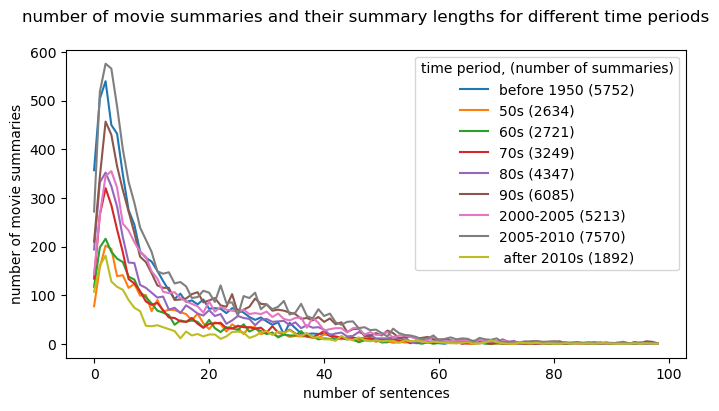

In [184]:
fig, ax = plt.subplots(figsize=(8,4))

sum = 0

for i, df in enumerate(time_periods_df_movies_summaries):
    data = []
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    plt.plot(data, label=str(time_period_labels[i]) + ' (' + str(np.sum(data))+')')
    sum += np.sum(data)
plt.legend(title='time period, (number of summaries)', fontsize=10)
ax.set_ylabel('number of movie summaries')
ax.set_xlabel('number of sentences')
plt.suptitle('number of movie summaries and their summary lengths for different time periods')

print('total number of movie summaries considered: ', 
      np.sum([len(x) for x in time_periods_df_movies_summaries]))

what about the proportions?

Text(0.5, 1.0, 'proportion of movie summaries and their summary lengths for different time periods')

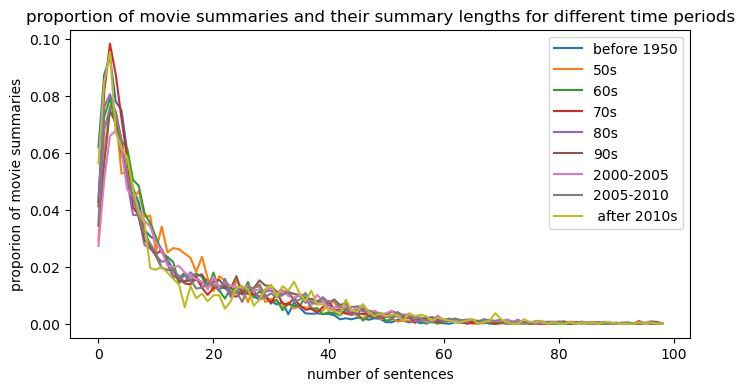

In [185]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(time_periods_df_movies_summaries):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    plt.plot(data, label=time_period_labels[i])
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('proportion of movie summaries and their summary lengths for different time periods')

Since the distribution of summary lengths is very similar for all periods of time, there should be no issues.

# Getting the subset of movies with genre "science-fiction" or "fantasy"
This approach is based on CMU genres combined with IMDB genre metadata

In [186]:
# remove movies without genre given
df_imdb_movie_genred = imdb_title_genre_df[~imdb_title_genre_df['genres'].isna()]
# Select rows where "Sci-Fi" or "Fantasy" appear in genres
df_imdb_fictional = df_imdb_movie_genred[df_imdb_movie_genred['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)]
# The full dataset from imdb
df_imdb_fictional.shape # row N = 312105

(312094, 9)

In [187]:
# Get all CMU movies which are fictional based IMDB dataset genres by merging on their name
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])

# Get summaries from movies that are genred as fictional in IMDB
df_fictional_summaries_idmb = df_summaries[df_summaries['Wikipedia_movie_ID'].isin(df_fictional_cmu_imdb['Wikipedia_movie_ID'])]

In [188]:
# Merging the result to have metadata information related to each summary

#movie_metadata_of_interest = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenu', 'movie_runtime', 'movie_genres', 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']
movie_metadata_of_interest = ['Wikipedia_movie_ID','movie_name','movie_release_date', 'movie_box_office_revenu', 'movie_runtime']

# Merge with movies to have more information related to each summary
df_fictional = pd.merge(df_fictional_summaries, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')
df_fictional_idmb = pd.merge(df_fictional_summaries_idmb, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')

# Find year based on cmu release date info (could be found also with imdb)
df_fictional['release_year'] = pd.to_datetime(df_fictional['movie_release_date'], format='mixed', errors='coerce').dt.year
df_fictional_idmb['release_year'] = pd.to_datetime(df_fictional_idmb['movie_release_date'], format='mixed', errors='coerce').dt.year

In [189]:
# Merge all summaries that have at least be found to be referenced as science fiction or fantasy in one of the datasets
df_fictional_summaries_all = pd.concat((df_fictional, df_fictional_idmb)).drop_duplicates('Wikipedia_movie_ID', keep='first')
print(df_fictional_summaries_all.shape) #(10871, 7)

(10871, 7)


In [190]:
df_fictional_summaries_all.head()

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0


# Visually exploring the subset of summaries

Text(0.5, 1.0, 'Count of movie summaries classified as fictional per year')

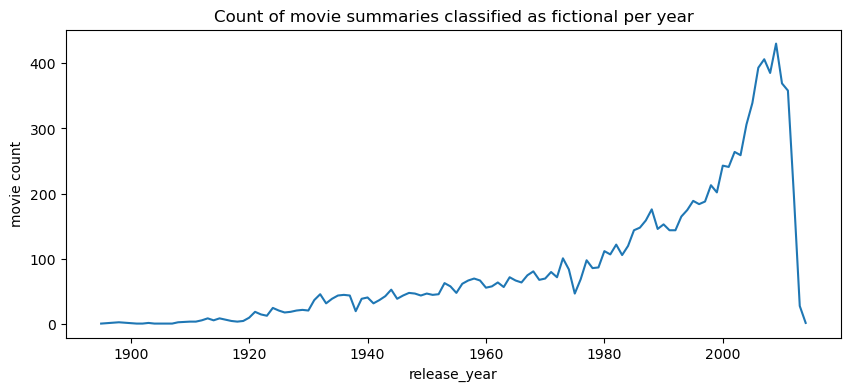

In [191]:
plt.figure(figsize=(10,4))
sns.lineplot(df_fictional_summaries_all.groupby('release_year')['Wikipedia_movie_ID'].agg("count"))
plt.ylabel('movie count')
plt.title('Count of movie summaries classified as fictional per year')

#Sentiment analysis: Adjustment for summary length and 

# sentiment of fictional movies

In [233]:
df_movies_summaries = pd.merge(df_movies_summaries, df_fictional_summaries_all[['Wikipedia_movie_ID']],
                                on='Wikipedia_movie_ID', how='left', indicator=True)

df_movies_summaries['fiction'] = df_movies_summaries['_merge'] == 'both'
df_movies_summaries = df_movies_summaries.drop(['_merge'], axis=1)
df_movies_summaries['fiction'] = df_movies_summaries['fiction'].fillna(False)

df_movies_summaries_fiction = df_movies_summaries[df_movies_summaries['fiction']==True].reset_index()
df_movies_summaries_nonfiction = df_movies_summaries[df_movies_summaries['fiction']==False].reset_index()

# add the sentiment scores to df_fictional_summaries_all
df_fictional_summaries_all = pd.merge(df_fictional_summaries_all, 
                                      df_movies_summaries[['sentence_sentiment_score', 'Wikipedia_movie_ID']],
                                        on='Wikipedia_movie_ID', how='left')

first we want to make sure that the distribtion of summary lengths among the fictional movies is not unusual

Text(0.5, 0.98, 'number of movie summaries and their summary lengths for fiction/non-fiction')

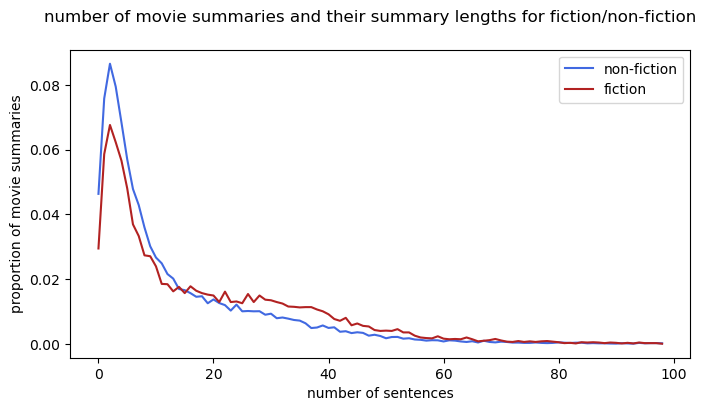

In [247]:
dfs = [df_movies_summaries[df_movies_summaries['fiction']==False],
       df_movies_summaries[df_movies_summaries['fiction']==True]]

fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(dfs):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 0:
        label = 'non-fiction'
        color='royalblue'
    else:
        label = 'fiction'
        color='firebrick'
    plt.plot(data, label=label, color=color)
plt.legend(fontsize=10)
ax.set_ylabel('proportion of movie summaries')
ax.set_xlabel('number of sentences')
plt.suptitle('number of movie summaries and their summary lengths for fiction/non-fiction')

sentiment of fictional movies for different periods of time

In [235]:
df_fiction_by_period = []
for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries_fiction[(df_movies_summaries_fiction.release_year > time_periods[i-1])
                                    & (df_movies_summaries_fiction.release_year <= time_periods[i])]
        df_fiction_by_period.append(temp)

In [236]:
df_non_fiction_by_period = []
for i in range(len(time_periods)):
    if i > 0:
        temp = df_movies_summaries_nonfiction[(df_movies_summaries_nonfiction.release_year > time_periods[i-1])
                                    & (df_movies_summaries_nonfiction.release_year <= time_periods[i])]
        df_non_fiction_by_period.append(temp)

Text(0.5, 1.0, 'Movie summaries by summary lengths for different time periods')

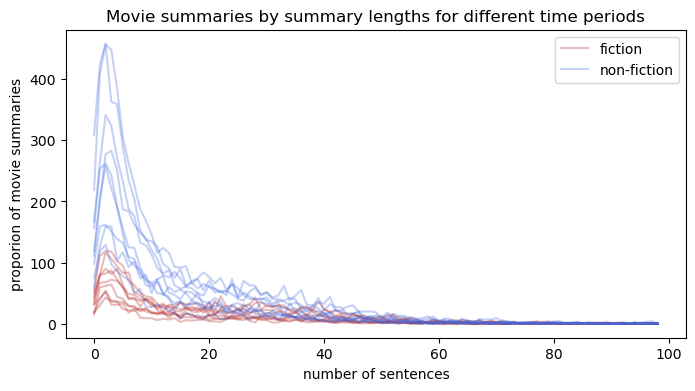

In [256]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(df_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    if i == 1:
        plt.plot(data, label='fiction', color='firebrick', alpha=0.3)
    else:
        plt.plot(data, color='firebrick', alpha=0.3)

for i, df in enumerate(df_non_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j]))
    if i == 0:
        plt.plot(data, label='non-fiction', color='royalblue', alpha=0.3)
    else:
        plt.plot(data, color='royalblue', alpha=0.3)
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('Movie summaries by summary lengths for different time periods')

Text(0.5, 1.0, 'Movie summary proportion by summary lengths for different time periods')

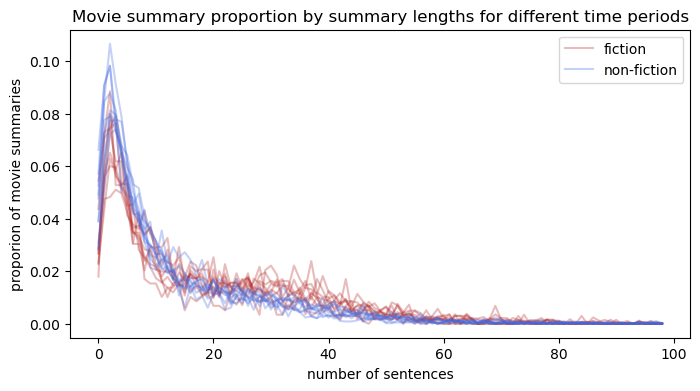

In [257]:
fig, ax = plt.subplots(figsize=(8,4))

for i, df in enumerate(df_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 1:
        plt.plot(data, label='fiction', color='firebrick', alpha=0.3)
    else:
        plt.plot(data, color='firebrick', alpha=0.3)

for i, df in enumerate(df_non_fiction_by_period):
    data = []
    n_datapoints = len(df)
    for j in range(1,100):
        data.append(len(df[df.n_sentences == j])/n_datapoints)
    if i == 0:
        plt.plot(data, label='non-fiction', color='royalblue', alpha=0.3)
    else:
        plt.plot(data, color='royalblue', alpha=0.3)
plt.legend()
ax.set_ylabel('proporion of movie summaries')
ax.set_xlabel('number of sentences')
ax.set_title('Movie summary proportion by summary lengths for different time periods')

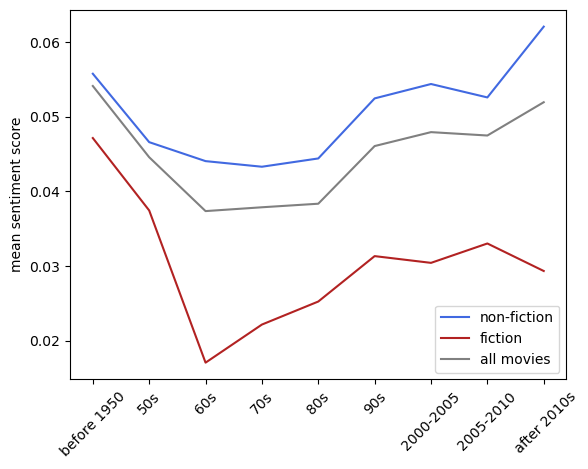

In [259]:
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in df_non_fiction_by_period],
         label='non-fiction', color='royalblue')
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in df_fiction_by_period], 
         label = 'fiction', color = 'firebrick')
plt.plot(time_period_labels, [np.mean(df.sentence_sentiment_score) for df in time_periods_df_movies_summaries], 
         label = 'all movies', color = 'grey')
time_periods_df_movies_summaries
plt.xticks(rotation=45)
plt.ylabel('mean sentiment score')
plt.legend()

do weighted averages of the summary lengths change anything?

In [ ]:
summary_lengths = range(1,70)

group_sentiments_len_sentence = pd.DataFrame(index=range(len(fiction_by_period)), 
                                             columns=summary_lengths)
weights_by_sentences =[]

uncounted_summaries = 0

for summary_length in summary_lengths:
    mean_sentiments_current_length = []
    n_movies_current_length = []
    
    # find out how many movies there are for current summary length
    for movie_group in fiction_by_period:
        temp = movie_group[movie_group['n_sentences'] == summary_length]
        n_movies_current_length.append(len(temp))
        mean_sentiments_current_length.append(np.mean(temp.sentiment_score))
    weights_by_sentences.append(min(n_movies_current_length))
    if min(n_movies_current_length) == 0:
        uncounted_summaries += sum(n_movies_current_length)
    group_sentiments_len_sentence[summary_length] = mean_sentiments_current_length

group_sentiments_len_sentence = group_sentiments_len_sentence.T

print('weights: ', weights_by_sentences)
print('fraction of uncounted summairies: ', uncounted_summaries/len(fantasy_scifi_movies))
group_sentiments_len_sentence

# Topic Modelling

In [197]:
from tqdm import tqdm

# natural language processing
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation

nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_md")

## i) Preprocess the summaries
Preprocessing the summaries involves, via tokenization, removing stop words and proper noun and taking only the lemma of each word.

In [198]:
def preprocess_docs(docs, nlp=nlp, batch_size=100, n_process=-1, entities_to_include = ['EVENT', 'DATE', 'LOC']):
    result_array = []
    for doc in tqdm(nlp.pipe(docs, disable=["parser", "textcat"], batch_size=batch_size, n_process=n_process)):
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ not in ['PROPN']]
        for ent in doc.ents:
            if ent.label_ in entities_to_include:
                element = ent.text.lower()
                for token in ent:
                    if (token not in tokens) and (not token.is_stop):
                        tokens.append(token.lemma_)

        result_array.append(" ".join(tokens))
    return result_array

In [199]:
docs = df_fictional_summaries_all['movie_summary']
result_array = preprocess_docs(docs, batch_size=64)
# takes around 3min

10871it [03:05, 58.76it/s] 


In [200]:
df_fictional_summaries_all['preprocessed_summary'] = result_array
df_fictional_summaries_all.head() #(10871, 8)

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,sentence_sentiment_score,preprocessed_summary
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,0.045261,nation consist wealthy poor district punishmen...
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,-0.061458,evil head give prophecy say find young child g...
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,-0.024432,great depression old fortune teller predict fu...
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,0.085621,career focus lawyer divorced father love spend...
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,0.033333,winter immediately liberation member french un...


In [201]:
#Preprocessing lead to some empty summaries
df_nan= df_fictional_summaries_all["preprocessed_summary"].isna()
df_empty = (df_fictional_summaries_all['preprocessed_summary'] == '')
df_fictional_summaries_all[df_nan | df_empty]

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,sentence_sentiment_score,preprocessed_summary
5435,1977161,*Richard Gere as Vincent Eastman *Sharon Ston...,Intersection,1994-01-21,NaN,98.0,1994.0,0.0,
7455,32250995,* Ally Walker: Audrey Macleah * Martin Sheen:...,When the Bough Breaks,1994-05-07,NaN,100.0,1994.0,0.0,


In [202]:
# Empty preprocessed summaries removal
df_fictional_summaries_all = df_fictional_summaries_all.drop(df_fictional_summaries_all[df_nan | df_empty].index)
df_fictional_summaries_all.shape #(10867, 8)

(10869, 9)

In [203]:
vectorizer5 = CountVectorizer(min_df=5)
dtm5 = vectorizer5.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
df_fictional_summaries_all['wordcount_min5freq'] = np.sum(dtm5, axis = 1) #number of word in the preprocessed summaries for each movie
dtm5.shape #(10867, 12600)

(10869, 12663)

In [204]:
df_fictional_summaries_all

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,sentence_sentiment_score,preprocessed_summary,wordcount_min5freq
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,0.045261,nation consist wealthy poor district punishmen...,319
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,-0.061458,evil head give prophecy say find young child g...,125
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,-0.024432,great depression old fortune teller predict fu...,269
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,0.085621,career focus lawyer divorced father love spend...,254
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,0.033333,winter immediately liberation member french un...,50
...,...,...,...,...,...,...,...,...,...,...
10866,24211707,The film follows a United States Border Patrol...,Borderline,1980-10-31,NaN,99.0,1980.0,-0.043276,film follow force track killer young mexican b...,601
10867,13348400,Jennie Lee is the lead singer of an all-girl ...,Satisfaction,1988-02-12,8253123.0,92.0,1988.0,0.059461,lead singer girl rock band name high school gr...,300
10868,277160,"Virginia ""Gin"" Baker is an investigator for W...",Entrapment,1999-04-30,212404396.0,113.0,1999.0,0.016089,investigator international art thief priceless...,163
10869,17736697,Paula Eastman is a Hollywood actress with an ...,Torch Song,1993-05-23,NaN,89.0,1993.0,-0.191667,actress alcohol problem career poorly sleep ac...,54


<Axes: xlabel='release_year', ylabel='wordcount_min5freq'>

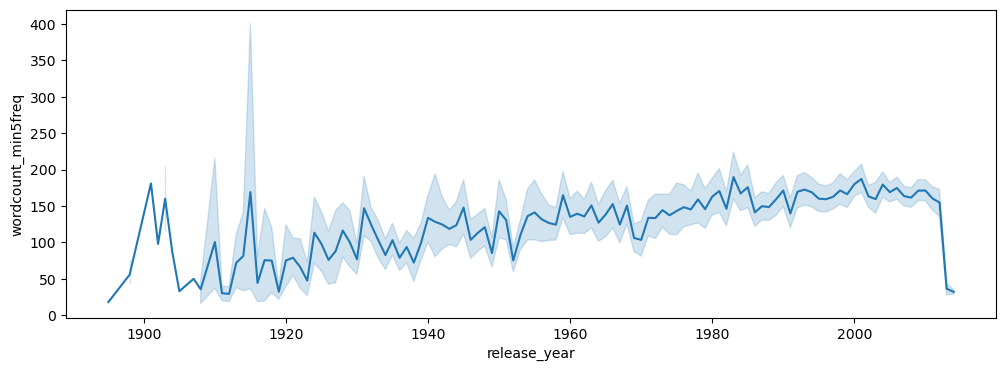

In [205]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_fictional_summaries_all.reset_index() , x = 'release_year', y = 'wordcount_min5freq')

After 1950, the mean number of words in the preprocessed summaries is more stable with a slight increase and variation of around 30 words. 
This is a good news because it means that if by performing a topic modelling on each decades after 1950, the results wont be biaised by the number of words per summaries. 

In [206]:
df_fictional_summaries_all['period'] = pd.cut(df_fictional_summaries_all.release_year,
                                              bins=[0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023],
                                              labels=['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', ' after 2010s'])

Text(0.5, 0, 'summary count')

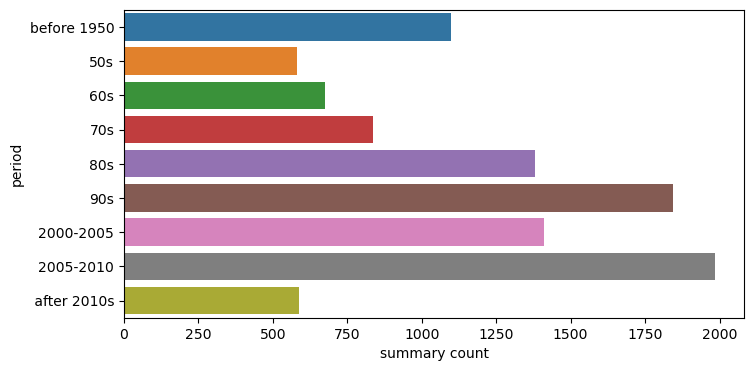

In [207]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_fictional_summaries_all, y='period')
plt.xlabel('summary count')

Text(0.5, 0, 'feature (tokens) count per summary')

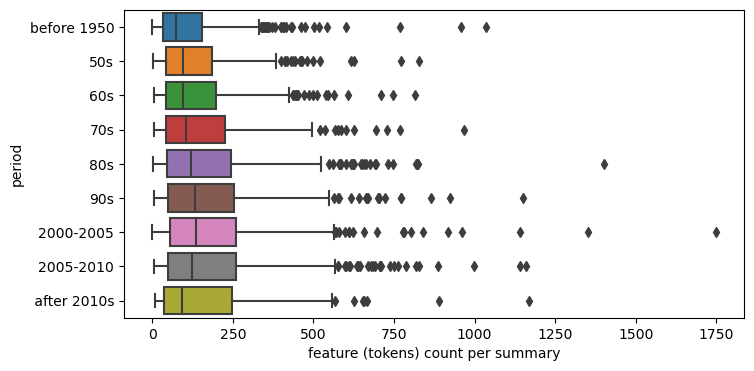

In [208]:
# plot token counts
plt.figure(figsize=(8,4))
sns.boxplot(data = df_fictional_summaries_all, x = 'wordcount_min5freq', orient='h', y = 'period')
plt.xlabel('feature (tokens) count per summary')

Text(0.5, 0, 'feature (tokens) count per summary')

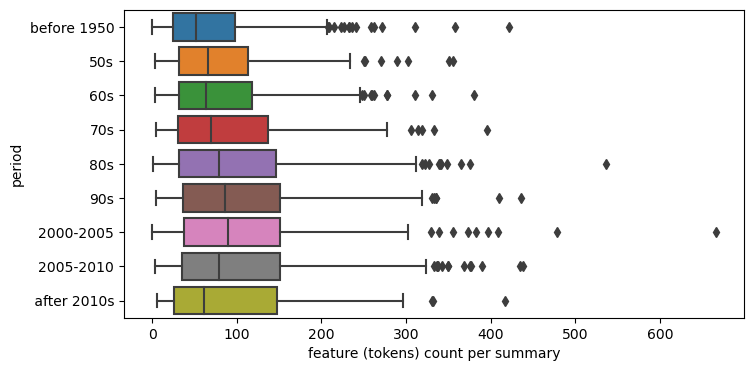

In [209]:
vectorizer5 = CountVectorizer(min_df=5, max_features=2500)
dtm5 = vectorizer5.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
df_fictional_summaries_all['wordcount_min5freq_n3000'] = np.count_nonzero(dtm5.toarray(), axis = 1) #number of word in the preprocessed summaries for each movie
# plot token counts
plt.figure(figsize=(8,4))
sns.boxplot(data = df_fictional_summaries_all, x = 'wordcount_min5freq_n3000', orient='h', y = 'period')
plt.xlabel('feature (tokens) count per summary')

## i) optional supp:  read/saving dataframe

In [210]:
file = os.path.abspath('output_data/df_summaries_preprocessed_all.csv')
task = 'read' # 'read', 'save

if task =='save':
    df_fictional_summaries_all.to_csv(file)
    print(f'saved df to {file}')
    
elif task=='read':
    df_fictional_summaries_all = pd.read_csv(file)
    print(f"Loaded dataframe from {file}")

Loaded dataframe from c:\Users\Cyrill\Documents\ada\project\ada-2023-project-thepiratesofthestreet\output_data\df_summaries_preprocessed_all.csv


## ii) LDA topic modelling overall

In [213]:
from topic_modeling import show_topics, plot_top_words, plot_tf_weights, plot_grid_search_score, lda_topic_modelling, save_top_words_weights

In [214]:
#docs = df_fictional_summaries_all[df_fictional_summaries_all.period=='before 1950']['preprocessed_summary']
docs = df_fictional_summaries_all['preprocessed_summary']

# Some parameter to fit
n_features = 8000

# Vectorize the summaries

# binary bag of words (good results)
vectorizer = CountVectorizer(stop_words='english', max_df = 0.5, min_df=10, ngram_range=(1,2), max_features=n_features, binary=True)

# row normalized bag of words (good results when overall)
vectorizer_norm = TfidfVectorizer(stop_words='english', max_df = 0.5, min_df=10, use_idf=False, ngram_range=(1,2), norm='l1')

dtm = vectorizer.fit_transform(docs)

# normalize matrix per row (not necessary since can use tfidf with use_idf = False)
#transformer = Normalizer(norm='l1').fit(dtm)
#dtm = transformer.transform(dtm)

dtm_norm = vectorizer_norm.fit_transform(docs)

tf_feature_names = vectorizer.get_feature_names_out()

dtm.shape, dtm_norm.shape # ((10867, X), (10867, X))

((10867, 8000), (10867, 20757))

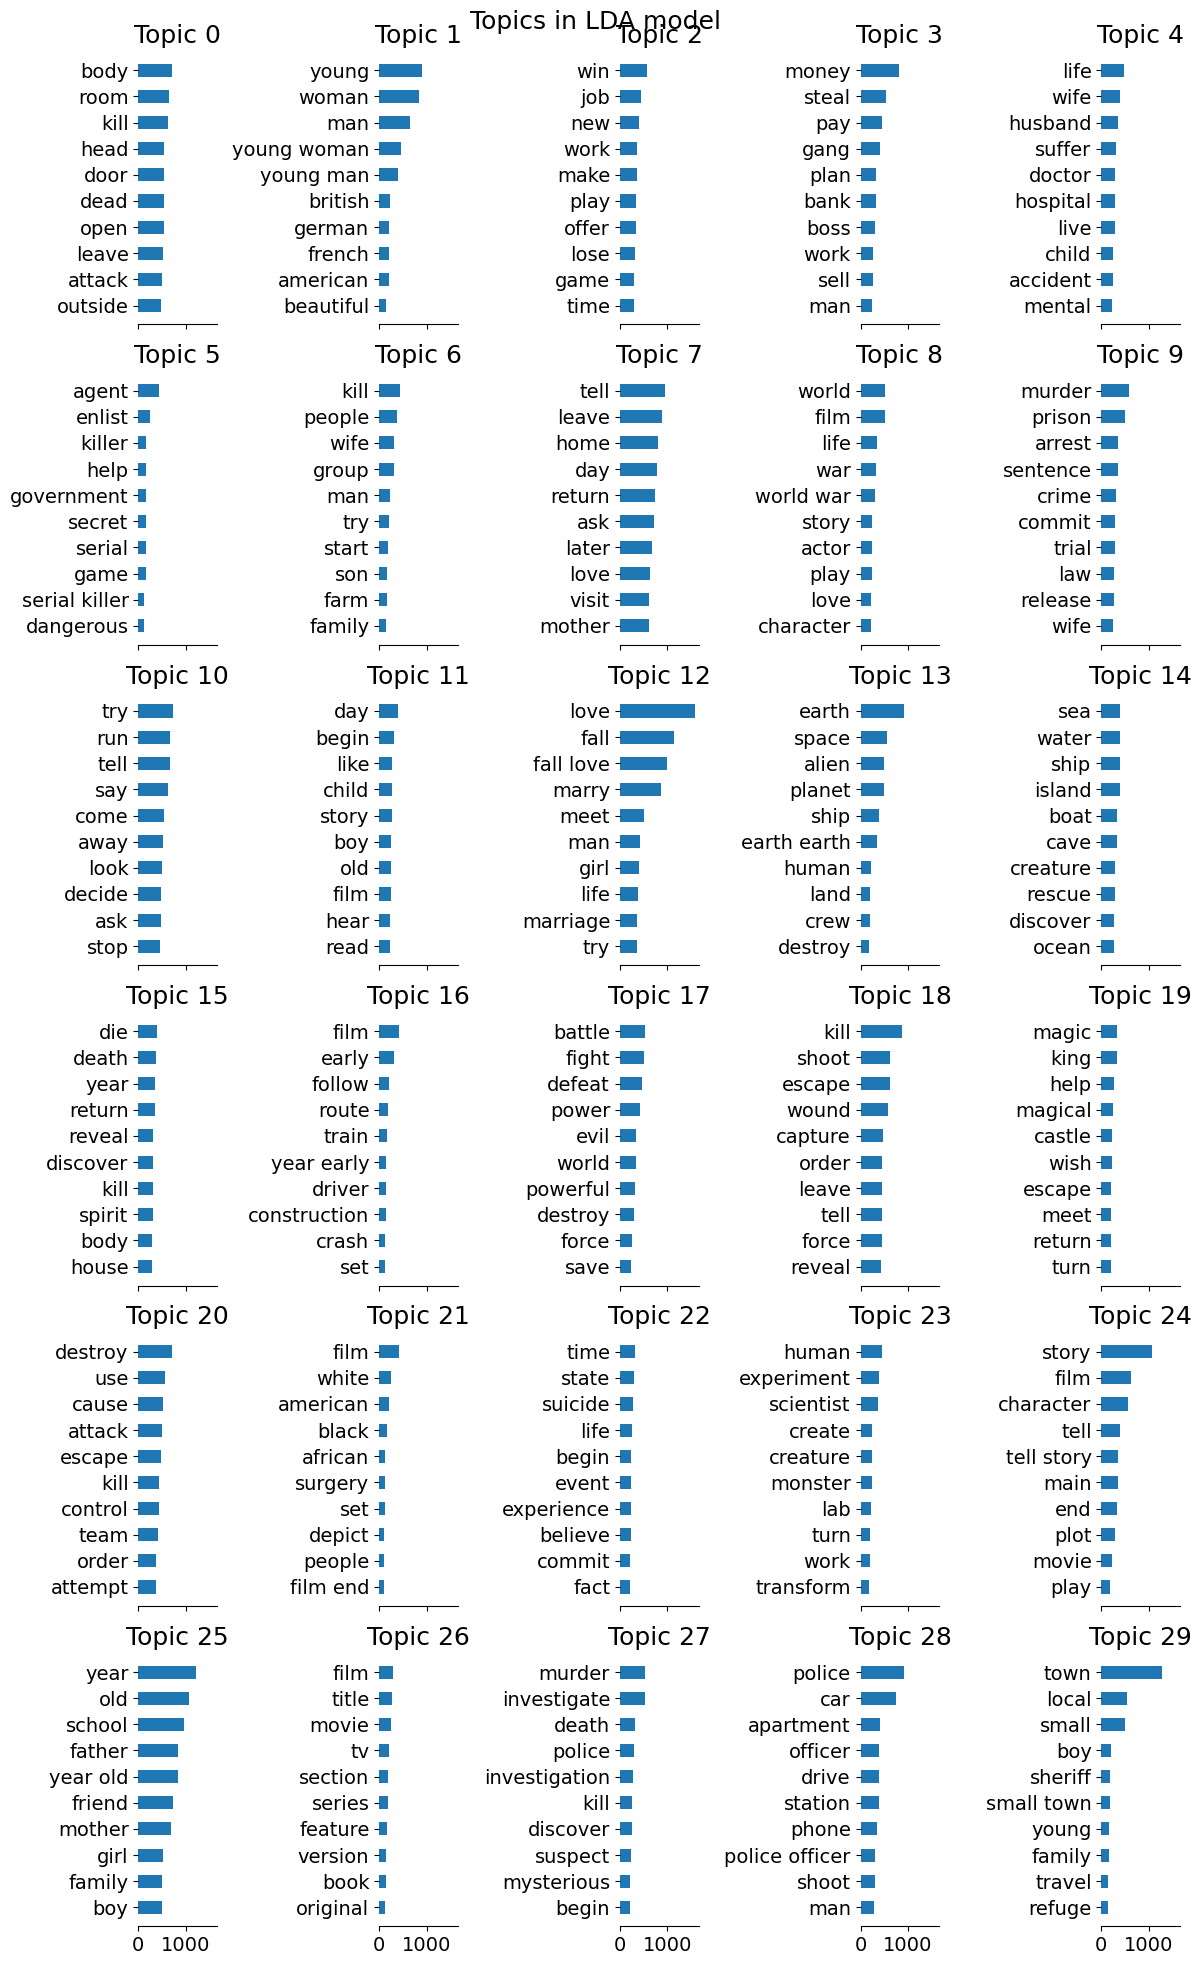

In [215]:
# General parameters to adapt
n_topics = 30
n_top_words = 10
alpha = 0.25
# doc_topic_prior:=alpha : represents the parameter of the Dirichlet prior on the per-document topic distributions. It influences how many topics are likely to be present in a document.
    # Higher alpha values result in documents with more topics, while lower values lead to sparser documents with fewer dominant topics.
beta = 0.05
# topic_word_prior := beta : represents the parameter of the Dirichlet prior on the per-topic word distributions. It controls the number of words associated with each topic.
#Similar to alpha, higher beta values result in topics with more words, while lower values lead to sparser topics.

random_state=7

# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(n_components=n_topics,
                                doc_topic_prior= alpha,
                                topic_word_prior= beta,
                                learning_method='batch',
                                max_iter=100,
                                random_state=random_state, n_jobs=-1, verbose=0)

lda.fit(dtm)
#lda.fit(dtm_norm)

# Plot the top n words for all topics
#topics_dict = plot_top_words(lda, vectorizer_norm.get_feature_names_out(), n_top_words=10, n_topics=n_topics, title="Topics in LDA model")
topics_dict = plot_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, n_topics=n_topics, title="Topics in LDA model")

In [ ]:
# Plot the top n words for all topics
topics_overall_df = save_top_words_weights(lda_model=lda, vectorizer=vectorizer, n=20, filename='output_data/lda_top_words_overall.csv')
topics_overall_df.head()

Word                                                                 \
Rank    0            1     2      3        4           5       6       7    
0     body        young   win  money     life       agent    kill    tell   
1     room        woman   job  steal     wife      enlist  people   leave   
2     kill          man   new    pay  husband      killer    wife    home   
3     head  young woman  work   gang   suffer        help   group     day   
4     door    young man  make   plan   doctor  government     man  return   

                           ...      Weight                          \
Rank         8         9   ...          20          21          22   
0         world    murder  ...  707.641504  410.908167  318.870906   
1          film    prison  ...  567.299673  255.132357  299.587648   
2          life    arrest  ...  522.131842  199.982211  272.175481   
3           war  sentence  ...  493.737864  176.813423  260.726564   
4     world war     crime  ...  481.661756      124.05  241.600981   

                                                                    \
Rank          23           24           25          26          27   
0     459.366129  1073.076484   1211.72065  291.056744  532.777198   
1         384.05   631.415032  1068.370791      282.05   528.50427   
2     370.931721    552.13556   961.617033  254.735212  310.609632   
3     242.456281   383.756532   834.918492  206.591785  290.157812   
4     241.414442       358.05       828.05  189.236253  270.038124   

                              
Rank          28          29  
0     923.589196     1268.05  
1     748.130592  532.242966  
2     416.494695  504.819969  
3     396.606927  206.125117  
4     385.408627      190.05  

[5 rows x 60 columns]

<Axes: >

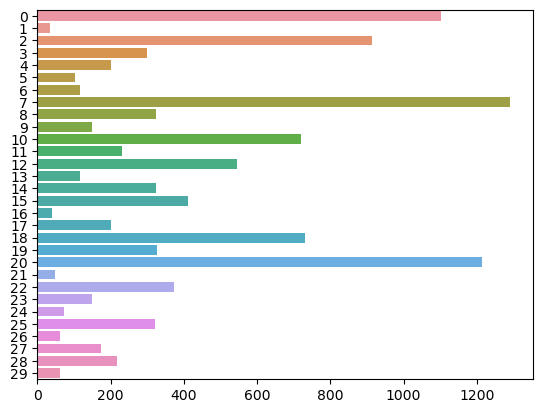

In [ ]:
# dtm=doc_topic_matrix is the matrix of document-topic probabilities obtained from lda.transform()

# Identify dominant topics for each summary and count per topic
dominant_topics = np.argmax(lda.transform(dtm), axis=1)

unique, counts = np.unique(dominant_topics, return_counts=True)

sns.barplot(x=counts, y = unique, orient='h')

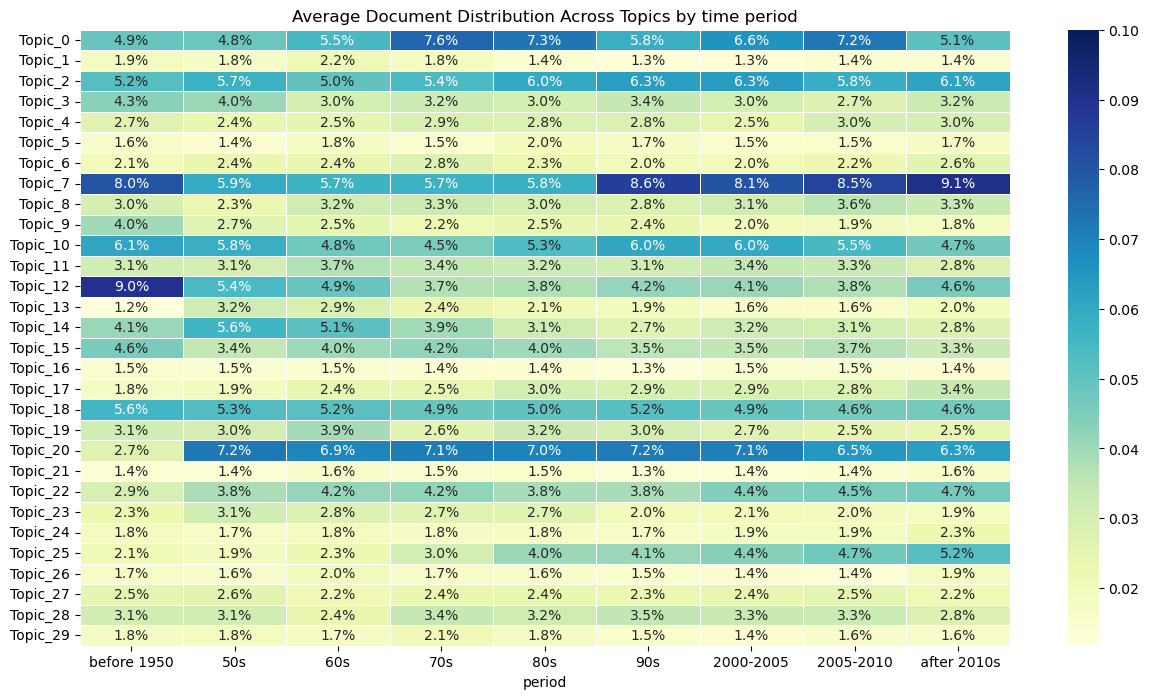

In [ ]:
# Transform documents into the topic probability space
doc_topic_probas = lda.transform(dtm)

# Create a DataFrame with the document-topic matrix
df_doc_topic = pd.DataFrame(doc_topic_probas, columns=[f'Topic_{i}' for i in range(lda.n_components)])

# Add information on the time period
df_doc_topic['period'] = df_fictional_summaries_all['period'].to_list()

# Group by decade and calculate the average topic probabilities
df_decade_avg = df_doc_topic.groupby('period').mean()

df_decade_avg.to_csv("output_data/topic_distrib_decade_avg.csv")

period_order = ['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', ' after 2010s']
# Plot a heatmap to visualize the document distribution across topics for each decade
plt.figure(figsize=(15, 8))
sns.heatmap(df_decade_avg.transpose()[period_order], cmap='YlGnBu', annot=True, fmt=".1%", linewidths=.5, vmax=0.1)
plt.title('Average Document Distribution Across Topics by time period')
plt.show()

### With gensim and coherence measure

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel

docs = df_fictional_summaries_all[df_fictional_summaries_all['period']=='60s']['preprocessed_summary']

tokenized_doc = []
for text in tqdm(docs):
    doc = nlp.tokenizer(text)
    tokenized_doc.append([token.text for token in doc])

  0%|          | 0/676 [00:00<?, ?it/s]

100%|██████████| 676/676 [00:00<00:00, 1705.15it/s]


In [ ]:
max_n_features = 2000

# Create a dictionary and corpus from the text documents
dictionary = corpora.Dictionary(tokenized_doc)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=max_n_features)

corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

# Convert the counts to binary representation
for doc in corpus:
    for i in range(len(doc)):
        doc[i] = (doc[i][0], 1)

In [ ]:
n_topics = 15
alpha = 0.3
eta = 0.05

# Train the LatentDirichletAllocation model
lda = models.LdaModel(corpus,  num_topics=n_topics, alpha = alpha, eta= eta,
                      random_state= 7,
                      passes = 20, iterations = 400)

In [ ]:
# Compute the topic coherence for each topic
coherence_model = CoherenceModel(lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_values = coherence_model.get_coherence_per_topic()

# Print the topic coherence scores for each model
print(coherence_values)

[-1.5259681263894849, -1.3018621991568613, -1.5131728070654868, -1.2141735966622462, -3.255208553477638, -1.51242073153841, -1.8407887850174312, -0.9984085189332407, -1.2024848595204818, -1.253792356629938, -1.754022241867019, -1.445592788360002, -1.1078389036427798, -1.5732973750375077, -1.930538048945261]


In [ ]:
import pyLDAvis.gensim_models
# plot topics
data =  pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.display(data)

## iii) Topics over Time

In [ ]:
for period, subset in df_fictional_summaries_all.groupby('period'):
    # Perform analysis on each subset
    print(f"Analyzing data for period: {period}")
    
    vectorizer = CountVectorizer(max_df=0.5, min_df=10, ngram_range = (1,2))
    #vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features, ngram_range=(1, 2), norm='l1')

    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(dtm.shape)

Analyzing data for period:  after 2010s


(587, 1449)
Analyzing data for period: 2000-2005
(1409, 3464)
Analyzing data for period: 2005-2010
(1982, 4665)
Analyzing data for period: 50s
(582, 1322)
Analyzing data for period: 60s
(676, 1569)
Analyzing data for period: 70s
(836, 2023)
Analyzing data for period: 80s
(1381, 3275)
Analyzing data for period: 90s
(1845, 4360)
Analyzing data for period: before 1950
(1098, 1990)


In [ ]:
def topic_modelling(subset, n_features=2000, binary_count = True,
                    n_topics = 15, alpha = 0.1, eta = 0.1,
                    max_iter = 50, random_seed = 7, n_top_words=10, norm = False, idf = False, sublinear_tf = False):
    
    if norm:
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, use_idf=False, norm='l1', sublinear_tf=sublinear_tf)
    elif idf:
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, use_idf=True, norm='l1',  sublinear_tf=sublinear_tf)
    else:
        vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2), max_features=n_features, binary=binary_count)
        
    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(f'Shape of the feature matrix is {dtm.shape}')

    # Create the LatentDirichletAllocation model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        doc_topic_prior= alpha, 
        topic_word_prior= eta,
        max_iter=max_iter,
        random_state=random_seed,
        verbose=0,
        learning_method='batch',
        n_jobs = -1
    )

    lda.fit(dtm)
    #lda.fit(dtm_normalized)
    return lda, vectorizer

def get_top_words_weights(lda_model, vectorizer, n=10):
    """
    Save the top n words and their weights for each topic in a CSV file.

    Parameters:
    - lda_model: The trained LDA model.
    - vectorizer: The vectorizer used for data transformation.
    - n: The number of top words to save for each topic.
    - filename: The name of the CSV file to save the results.

    Returns:
    None
    """
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Create a MultiIndex for the DataFrame columns
    columns = pd.MultiIndex.from_product([['Word', 'Weight'], range(0, len(lda_model.components_))], names=[None, 'Rank'])

    # Create a DataFrame to store the results
    top_words_df = pd.DataFrame(index=range(n), columns=columns)
    # Iterate through each topic in the LDA model
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get the indices of the top n words for the current topic
        top_features_ind = topic.argsort()[-n:][::-1]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        # Assign the values to the DataFrame
        top_words_df.loc[:,('Word', topic_idx)] = top_features
        top_words_df.loc[:,('Weight', topic_idx)] = weights

    return top_words_df


def plot_topwords_heatmap(lda = None, vectorizer=None, df_word_ranks=None, n_top_words = 10, title = None, save_to_filename = None ):
    '''Plots the top n words as '''
    if df_word_ranks is None:
        if lda is None | vectorizer is None:
            raise(ValueError("Either lda and vectorizer should be given, or directly word and weight dataframe."))
        df_word_ranks = get_top_words_weights(lda ,vectorizer, n=n_top_words)
    else:
        if df_word_ranks.shape[0]!=n_top_words:
            n_top_words = df_word_ranks.shape[0]
    
    # Create a heatmap
    plt.figure(figsize=(15, 5))
    sns.heatmap(df_word_ranks['Weight'].T.astype(float), cmap='YlGnBu', annot=df_word_ranks['Word'].T, fmt="", linewidths=.5)
    
    # Customize the plot
    if title is None:
        plt.title(f'Top {n_top_words} Words for Each Topic')
    else:
        plt.title(title)

    plt.xlabel('Word Rank')
    plt.ylabel('Topics')

    if save_to_filename:
        print(f"saving figure to {save_to_filename}")
        plt.savefig(save_to_filename)
    
    plt.show()
    return

> we search for the topics of sci fiction with the hypothesis that 15 topics is a good estimate which could include also some less important topics in term of word appearance.
> Each movies would tipycally be represented by around 3 topics (for example war, spaceships, love). this could be parametrized 

### 1) before 50s

In [ ]:
# get subset of summaries before 1950
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='before 1950']
# LDA topic modelling of the subset
lda_b50s, vectorizer_b50s = topic_modelling(subset, n_topics=15, alpha=0.15, eta = 0.05, max_iter = 100, random_seed=10)

Shape of the feature matrix is (1098, 1940)


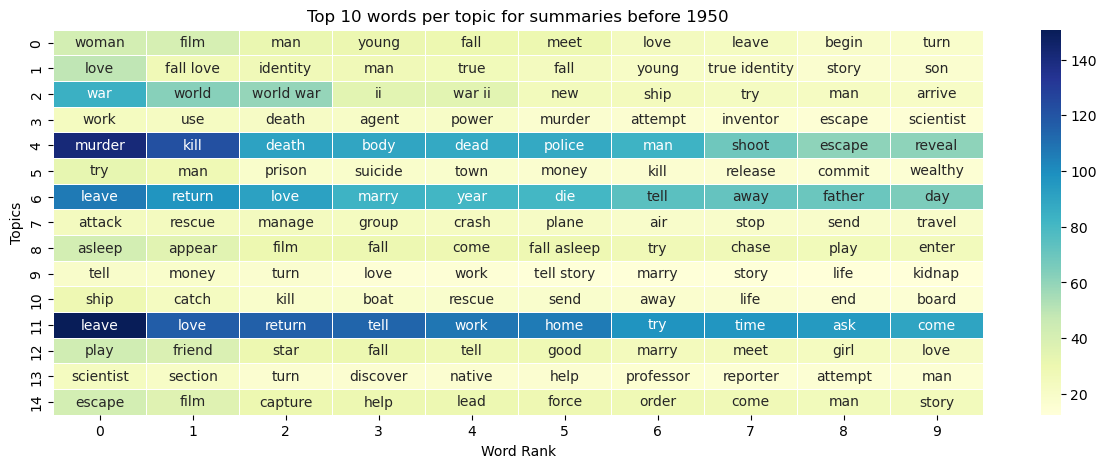

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_b50s = get_top_words_weights(lda_b50s, vectorizer_b50s, n=10)
df_top10words_b50s.to_csv("output_data/df_top10words_b50s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_b50s, title='Top 10 words per topic for summaries before 1950')

Topic on scientist is recurring and stable, with world war, the ship adventure, the scientist-discover, the murder-police, the typical Leave, love, etc..,

### 2) 50s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='50s']
lda_50s, vectorizer_50s = topic_modelling(subset, n_topics=15, alpha=0.2, eta = 0.05, random_seed=5, norm = True)

Shape of the feature matrix is (582, 1295)


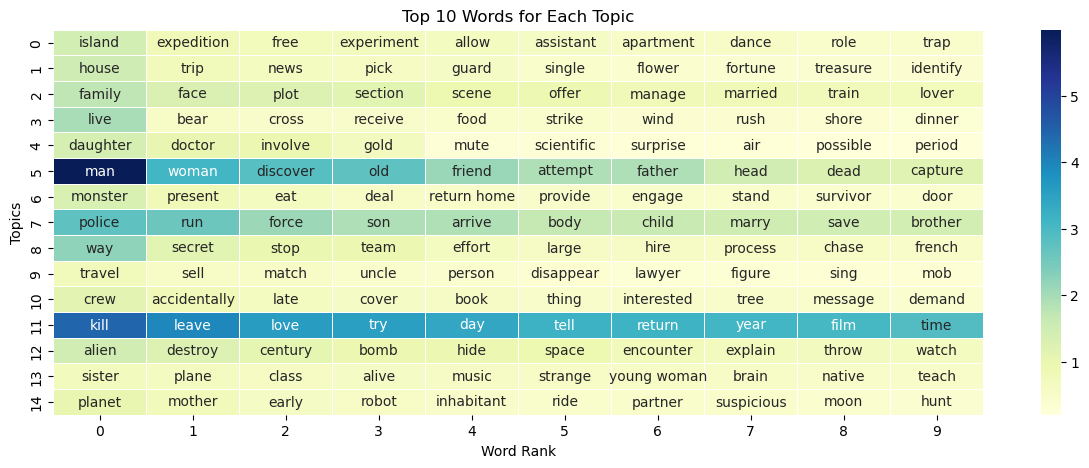

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_50s = get_top_words_weights(lda_50s, vectorizer_50s, n=10)
df_top10words_50s.to_csv("output_data/df_top10words_50s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_50s)

It is interesting to note the "monster" "planet" and "alien" being separated into different topics. 

### 3) 60s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='60s']
lda_60s, vectorizer_60s = topic_modelling(subset, n_topics=15, max_iter=100, alpha=0.25, eta = 0.01, random_seed=5)
# less movies so adjust alpha to have fewer "topics" per summary

Shape of the feature matrix is (676, 1539)


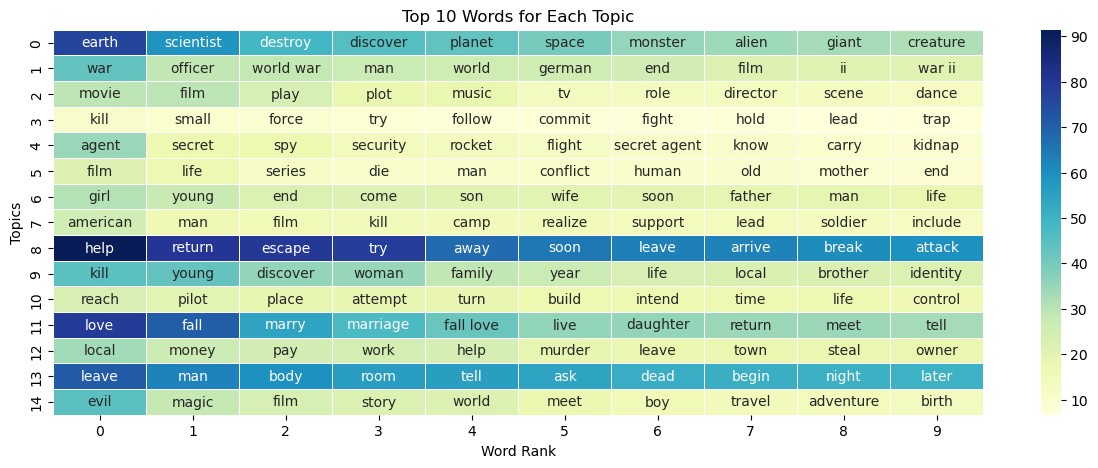

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_60s = get_top_words_weights(lda_60s, vectorizer_60s, n=10)
df_top10words_60s.to_csv("output_data/df_top10words_60s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_60s)

### 4) 70s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='70s']
lda_70s, vectorizer_70s = topic_modelling(subset, n_features=None, n_topics=15, alpha=0.2, eta = 0.05, random_seed=8, max_iter=100, binary_count=True)

Shape of the feature matrix is (836, 1972)


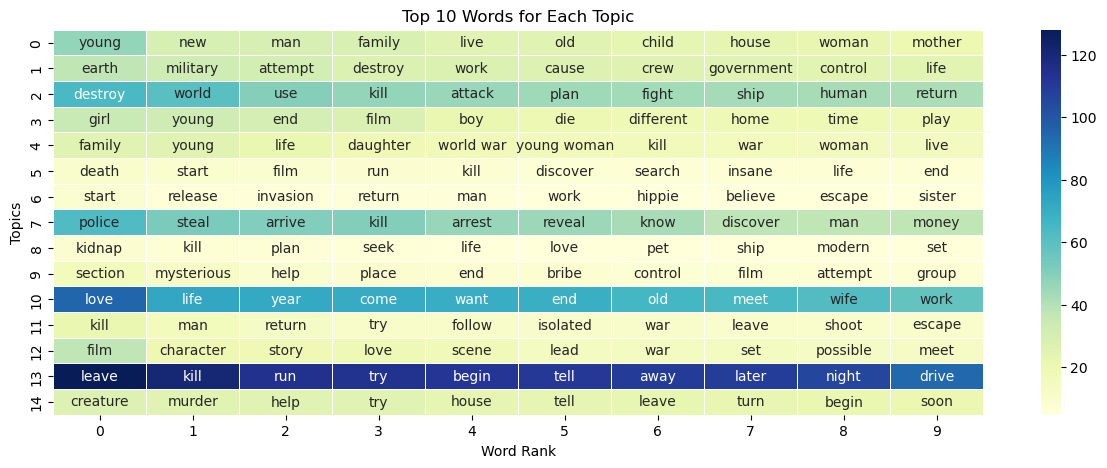

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_70s = get_top_words_weights(lda_70s, vectorizer_70s, n=10)
df_top10words_70s.to_csv("output_data/df_top10words_70s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_70s)

### 5) 80s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='80s']
lda_80s, vectorizer_80s = topic_modelling(subset, n_features=3000, n_topics=15, alpha=0.1, eta = 0.01, random_seed=8, max_iter=50, binary_count=True)

Shape of the feature matrix is (1381, 3000)


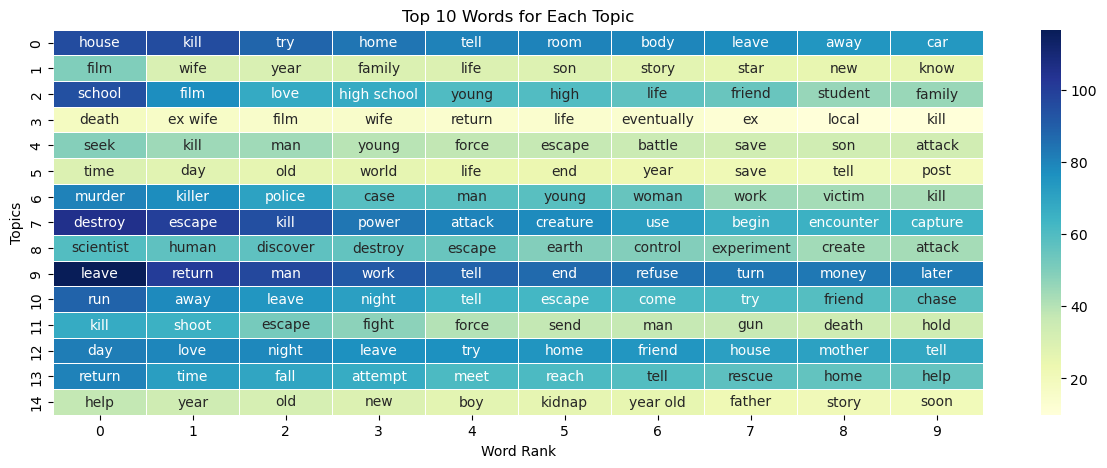

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_80s = get_top_words_weights(lda_80s, vectorizer_80s, n=10)
df_top10words_80s.to_csv("output_data/df_top10words_80s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_80s)

### 6) 90s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='90s']
lda_90s, vectorizer_90s = topic_modelling(subset, n_features=2000, n_topics=15, alpha=0.2, eta = 0.1, random_seed=8, max_iter=40, binary_count=True)

Shape of the feature matrix is (1845, 2000)


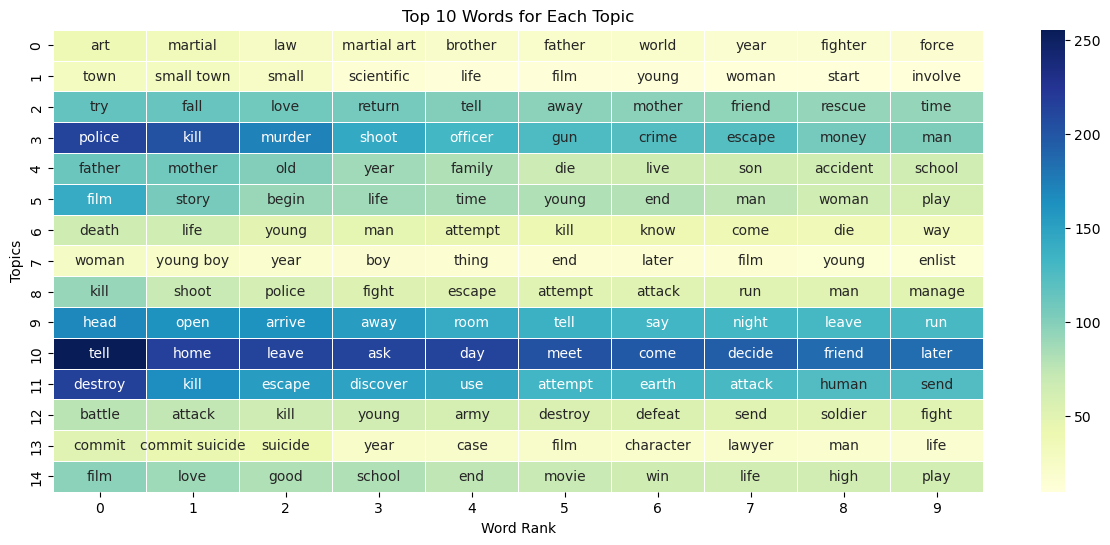

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_90s = get_top_words_weights(lda_80s, vectorizer_90s, n=10)
df_top10words_90s.to_csv("output_data/df_top10words_90s.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_90s)

### 7) 2000-2005

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='2000-2005']
lda_00_05, vectorizer_00_05 = topic_modelling(subset, n_features=2000, n_topics=15, alpha=0.15, eta = 0.05, random_seed=5, max_iter=100, binary_count=True)

Shape of the feature matrix is (1409, 2000)


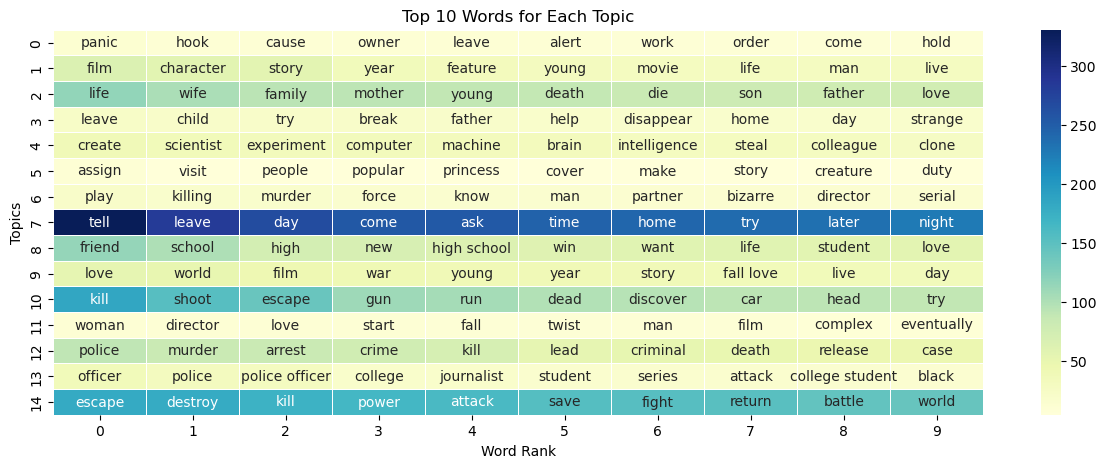

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_00_05 = get_top_words_weights(lda_00_05, vectorizer_00_05, n=10)
df_top10words_00_05.to_csv("output_data/df_top10words_00_05.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_00_05)

we observe already how governement and scientis topic becomes more present (and stable to random). World War dissappears.

### 8) 2005-2010

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='2005-2010']
lda_05_10, vectorizer_05_10 = topic_modelling(subset, n_features=1500, n_topics=15, alpha=0.15, eta = 0.05, random_seed=8, max_iter=400, binary_count=True)

Shape of the feature matrix is (1982, 1500)


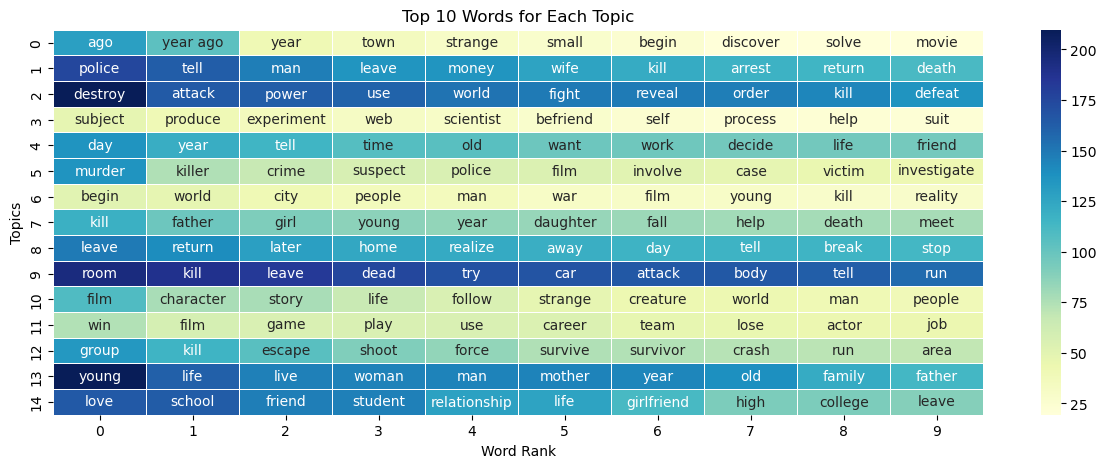

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_05_10 = get_top_words_weights(lda_05_10, vectorizer_05_10, n=10)
df_top10words_05_10.to_csv("output_data/df_top10words_00_05.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_05_10)

### 9) 10s

In [ ]:
subset = df_fictional_summaries_all[df_fictional_summaries_all['period']==' after 2010s']
lda_10s, vectorizer_10s = topic_modelling(subset, n_features=1500, n_topics=15, alpha=0.05, eta = 0.01, random_seed=7, max_iter=100, binary_count=True)

Shape of the feature matrix is (587, 1409)


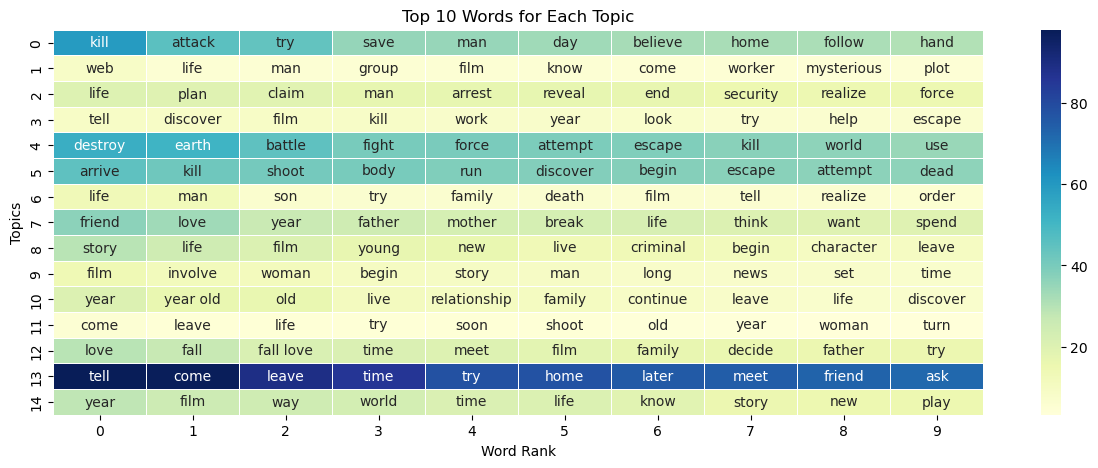

In [ ]:
# Get the top10 words of each topic and their weight
df_top10words_10s = get_top_words_weights(lda_10s, vectorizer_10s, n=10)
df_top10words_05_10.to_csv("output_data/df_top10words_10.csv")
# Plot the result as a heatmap to be concise
plot_topwords_heatmap(df_word_ranks=df_top10words_10s)

# Search for specific topics over time

In [ ]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load pre-trained spaCy model
nlp = spacy.load('en_core_web_md')

# Vector representation of the word 'alien'
aliens_vector = nlp('alien').vector

# Function to calculate cosine similarity between two vectors
def cosine_similarity_to_alien(text):
    text_vector = nlp(text).vector
    return cosine_similarity([aliens_vector], [text_vector])[0][0]

subset = df_fictional_summaries_all[df_fictional_summaries_all['period']=='50s']

text_vector = np.array([nlp(text).vector for text in subset['preprocessed_summary']])

subset['cosine_similarity_to_alien'] = cosine_similarity([aliens_vector], text_vector)[0]

Empty DataFrame
Columns: [movie_summary]
Index: []


C:\Users\gezas\AppData\Local\Temp\ipykernel_15960\2005684901.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cosine_similarity_to_alien'] = cosine_similarity([aliens_vector], text_vector)[0]


<Axes: xlabel='cosine_similarity_to_alien', ylabel='Count'>

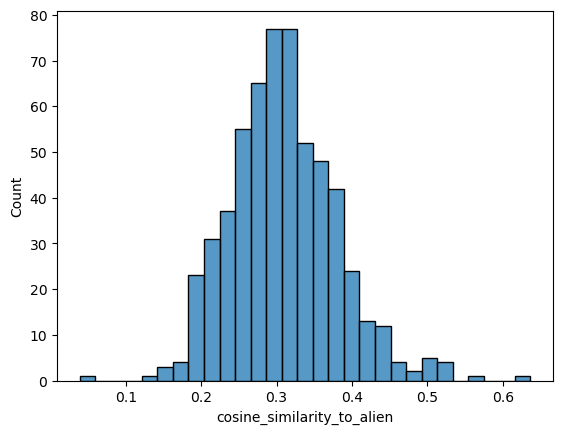

In [ ]:
sns.histplot(subset['cosine_similarity_to_alien'])

In [ ]:
# Set a threshold to filter summaries with high similarity to the word 'alien'
threshold = 0.4
aliens_related_summaries_embeddings = subset[subset['cosine_similarity_to_alien'] > threshold]
print(aliens_related_summaries_embeddings.size)

# Print or further analyze the selected summaries
print(aliens_related_summaries_embeddings[['movie_summary']])

832
                                           movie_summary
228    Rocky Jones attempts to save the inhabitants o...
378    An earthquake has led to the hatching of eggs ...
516    The movie begins when a fisherman is killed by...
622    In 1957, Commander Dr. Eldon Galbraithe , engi...
650    Test pilot Bruce Barton  is missing and his gi...
921    Nyah, a sexy, commanding female alien dressed ...
1043   A monomaniacal scientist, Dr. Laird , has inve...
1151   A spaceship lands in the woods. A teenage coup...
1237   The story revolves around a tribe of primitive...
1295   Four astronauts in 1960 travel to a planet cal...
1367   The Stooges tells their infant sons  a story a...
1450   Maj. Joe Nolan  is the head of a mission to th...
1456   Following the Gill-man's escape from Ocean Har...
1469   The film starts with narration from Mother Nat...
1500   The story involves the discovery of signs of l...
1509   Mitch MacAfee , while engaged in a radar test ...
1533   A rocket-ship carryi

In [ ]:
aliens_related_summaries_embeddings['movie_summary'][7391]

"Duncan Marsh , a mild-mannered man, finds himself lost in a remote village called Mountaincrest. His mind is clouded, but he learns later that Emory Forrest  and Morgan Chambers , two scientists, injected him with a special serum containing irradiated wolf's blood when he was suffering from amnesia after being in a car accident. The wolf's blood, for unknown reasons, changed the previously gentlemanlike Duncan into a vicious, bloodthirsty werewolf."

### Other method: check if contains string (direct and efficient method)

<Axes: xlabel='contains_alien', ylabel='period'>

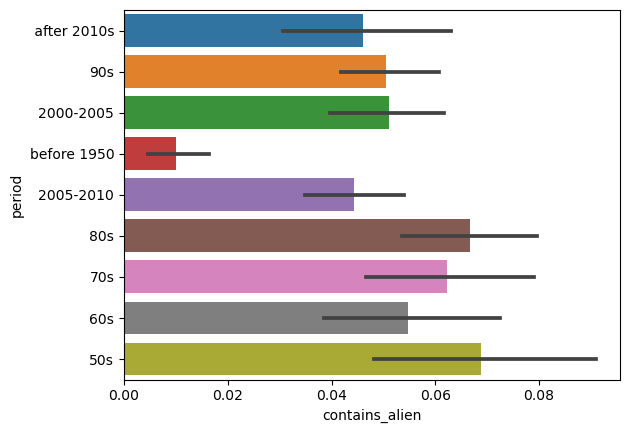

In [ ]:
df_fictional_summaries_all["contains_alien"] = df_fictional_summaries_all['preprocessed_summary'].str.contains('alien', case=False)
sns.barplot(df_fictional_summaries_all, y = 'period', x = 'contains_alien', orient='h')

# Try to search similar words

In [ ]:
def get_similar_words(words='alien', df_summaries=df_fictional_summaries_all, top_n_words=10, nlp = nlp):
    vectorizer_words = CountVectorizer(min_df=5)
    vectorizer_words.fit(df_summaries['preprocessed_summary'])

    all_unique_features = vectorizer_words.get_feature_names_out()

    sim_words = []
    # Use spaCy's pipe method for parallel processing
    for doc in tqdm(nlp.pipe(all_unique_features, disable=["tagger", "parser", "ner"], batch_size=1000, n_process=-1)):
        similarity = nlp(words).similarity(doc)
        sim_words.append(similarity)

    descending_indices = np.array(sim_words).argsort()[::-1]

    return all_unique_features, sim_words

# Takes 4min to go over all elements

In [ ]:
a,b = get_similar_words(words='space', df_summaries=df_fictional_summaries_all.sample(500))

0it [00:00, ?it/s]C:\Users\gezas\AppData\Local\Temp\ipykernel_4148\969940192.py:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = nlp(words).similarity(doc)
2410it [00:48, 49.30it/s]


In [ ]:
word_list = ["alien", "ufo", "extraterrestrial"]

# Check if any of the words in word_list is present in 'summary_text'
df_fictional_summaries_all['contains_alien_related_word'] = df_fictional_summaries_all['movie_summary'].str.contains('|'.join(word_list), case=False)

# Filter the DataFrame to show only rows where any of the words is present
filtered_df = df_fictional_summaries_all[df_fictional_summaries_all['contains_alien_related_word']]

index_1 = filtered_df.index
# Print or further analyze the filtered DataFrame
print(filtered_df[['movie_summary']].shape)

(612, 1)


In [ ]:
word_list = ["alien", " ufo ", "extraterrestrial"]

# Check if any of the words in word_list is present in 'summary_text'
df_fictional_summaries_all['contains_alien_related_word'] = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(word_list), case=False)

# Filter the DataFrame to show only rows where any of the words is present
filtered_df = df_fictional_summaries_all[df_fictional_summaries_all['contains_alien_related_word']]

index_2 = filtered_df.index
# Print or further analyze the filtered DataFrame
print(filtered_df[['movie_summary']].shape)

(580, 1)


In [ ]:
print(index_1[~index_1.isin(index_2)])
print(df_fictional_summaries_all['movie_summary'][2884])
print([cosine_similarity([nlp("alien").vector], [nlp(df_fictional_summaries_all['movie_summary'][i]).vector])[0][0] for i in index_1[~index_1.isin(index_2)]])

Index([  55,  258,  474,  501,  507,  510,  837, 1122, 1385, 1811, 1851, 2138,
       2193, 2254, 2459, 2527, 2593, 2777, 2803, 2884, 2920, 2951, 3079, 3135,
       3163, 3171, 3614, 4357, 4552, 6277, 9358, 9393],
      dtype='int64')
Two Evil Alien Conquerors are sent to Earth with the order to behead all humans within 48 hours. If they fail, they will be destroyed by Croker, a 100ft tall giant. Kenny  witnesses the Evil Alien Conquerors, My-ik  and Du-ug , as they arrive on Earth, literally falling out of the sky with their beheading swords. He offers them shelter at his home, which he shares with Ron, an unpleasant, oversexed infomercial producer. The conquering duo have a chance to experience Earth culture, where they become friends with Kenny, develop a fondness for Schmirnoff Ice and unexpectedly fall in love with two local women, who have a secret of their own. They begin to doubt what they were sent to do, but know they still must attempt to complete their impossible mission de

[0.24627128, 0.25031766, 0.23863018, 0.0922818, 0.25479, 0.24665059, 0.23629886, 0.22624284, 0.25595996, 0.25014326, 0.27641788, 0.25757775, 0.2510286, 0.3245132, 0.2682575, 0.23729771, 0.22145808, 0.2585138, 0.2514047, 0.31429043, 0.2601121, 0.119196765, 0.27254188, 0.277417, 0.29581276, 0.3280157, 0.2656582, 0.22109978, 0.31655958, 0.26767862, 0.23659405, 0.27722535]


In [ ]:
df_fictional_summaries_all['preprocessed_summary'][178]

'return groundbreaking original film premise travel time body daughter mission save life save world lethal trancer adapt survive girl avoid assassination attempt powerful dangerous zombie like trancer face'

In [ ]:
time_travel_keywords = [
    "time travel",
    "travel time",
    "temporal displacement",
    "Time dilation",
    "time machine",
    "temporal journey",
    "time loop",
    "time manipulation",
    "temporal paradox",
    "time warp"
]

time_travel_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(time_travel_keywords), case=False)
time_travel_mask.sum()
#sns.countplot(df_fictional_summaries_all[time_travel_mask], x='period')

146

<Axes: xlabel='release_year', ylabel='count'>

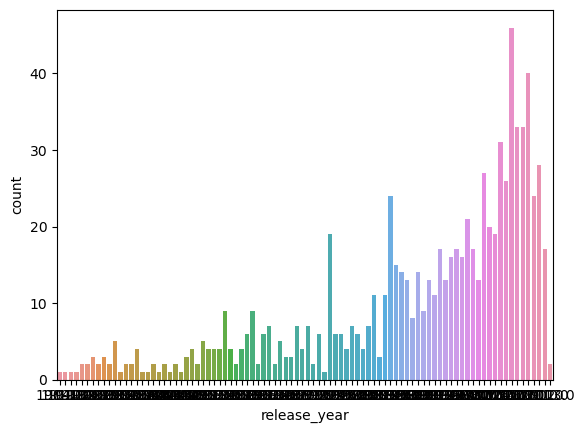

In [ ]:
government_keywords = [
    "government",
    "society",
    "politics",
    "regime",
    "council"
]
governement_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(government_keywords), case=False)
sns.countplot(df_fictional_summaries_all[governement_mask], x = 'release_year')

<Axes: xlabel='release_year', ylabel='count'>

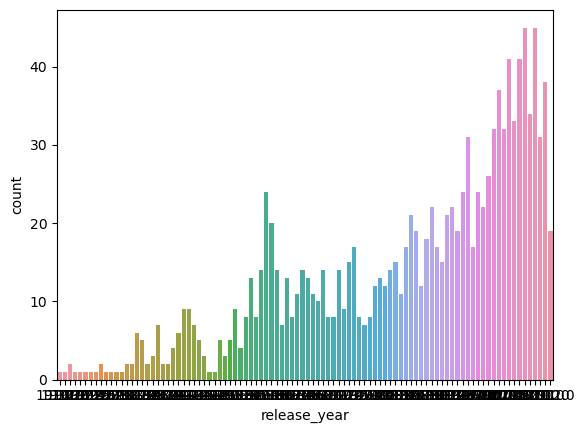

In [ ]:
scientist_keywords = [
    "scientist",
    "science",
    "researcher",
    "experiment",
    "experimentation",
    "laboratory"
]

science_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(scientist_keywords), case=False)
sns.countplot(df_fictional_summaries_all[science_mask], x = 'release_year')

<Axes: xlabel='release_year', ylabel='count'>

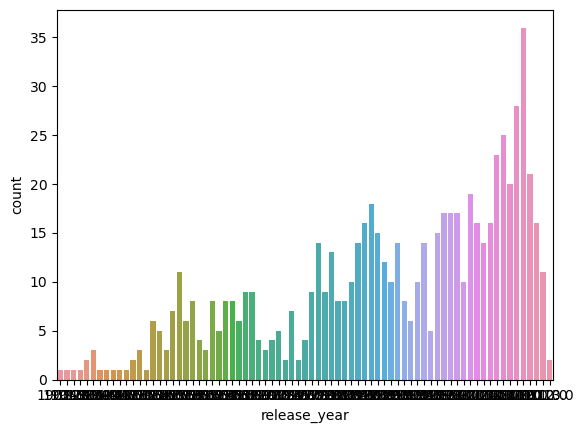

In [ ]:
space_keywords = [
    "space",
    "spaceship"
]
space_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(space_keywords), case=False)
sns.countplot(df_fictional_summaries_all[space_mask], x = 'release_year')

In [ ]:
mutants = [
    "mutant",
    "mutant creature",
    "radiation mutant",
    "genetic anomaly",
    "genetic experiment",
    "genetic modified",
    "mutant animal",
    "mutant creature",
    "mutant specie",
    "genetically alter organism",
    "mutant evolution",
    "mutant genetics",
    "mutant powers",
    "mutant abilities",
    "mutant origin",
    "mutant virus",
    "genetic mutation",
    "experimental mutation",
    "evolved mutant",
    "mutant universe",
    "new species mutation",
    "genetic modification"
]
mutants_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(mutants), case=False)
print(mutants_mask.sum())

119


<Axes: xlabel='release_year', ylabel='count'>

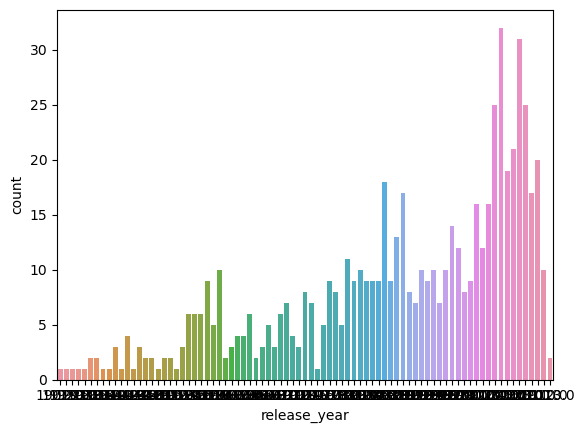

In [ ]:
creature_mask = df_fictional_summaries_all['preprocessed_summary'].str.contains(" creature ", case=False)
sns.countplot(df_fictional_summaries_all[creature_mask], x='release_year')

879


<Axes: xlabel='release_year', ylabel='count'>

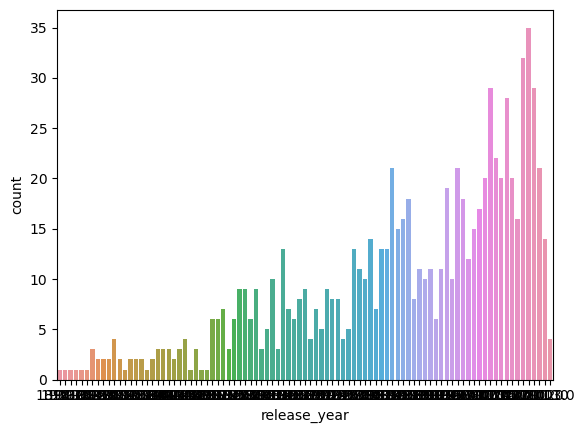

In [ ]:
planet_keywords = ["planet", "moon", "mars", "saturn", "venus"]

planet_movies = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(planet_keywords), case=False)
print(planet_movies.sum())
sns.countplot(df_fictional_summaries_all[planet_movies], x='release_year')

879


<Axes: xlabel='release_year', ylabel='count'>

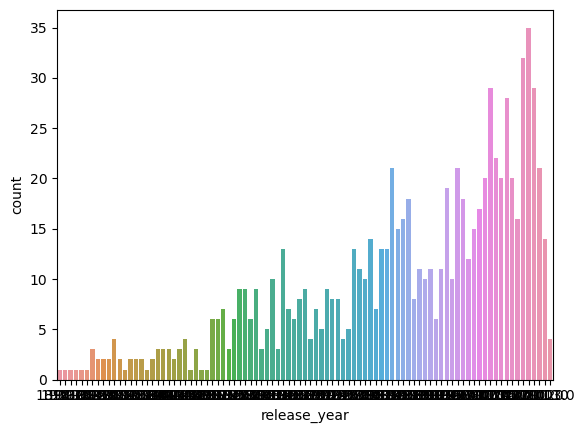

In [ ]:
spaceship = ["spaceship", 'satellite', 'space crew', "cosmonaut"]
spaceship_movies = df_fictional_summaries_all['preprocessed_summary'].str.contains('|'.join(planet_keywords), case=False)
print(spaceship_movies.sum())
sns.countplot(df_fictional_summaries_all[spaceship_movies], x='release_year')

In [ ]:
df_fictional_summaries_all[mutants_mask]['movie_summary'][132]

'Tracking two lost lumberjacks through the night, a rescue team nearly follows a hound over a cliff. Two men rappel down to retrieve the fallen hound, but they are killed. The third, hearing screams down below, rappels down to investigate, where he finds his team mates dead, killed by a unknown thing. The third is then, killed by a unseen force Dr. Robert Verne  is fed up with dealing with the squalor of city tenements. He does not feel he is making a difference. He accepts a job from the Environmental Protection Agency to write a report on a logging operation near the Androscoggin River in Maine. The loggers are in a dispute with the local American Indian "Opies" , the original people. Dr. Verne\'s wife Maggie  accompanies him on the trip. She is pregnant but is apprehensive to tell her husband as he is set against having children. When they fly in, they meet a man, Travis Nelson  and his two children Paul and Kathleen who are embarking on a trek into the wilderness. They also meet Be